# Saudi Containment and Closure Policies effects on COVID-19 Pandemic


## Importing Required Packages

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
import json
import datetime
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import altair as alt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import missingno as msno
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from lime.lime_tabular import LimeTabularExplainer
import lime

warnings.filterwarnings("ignore")

## 1. Data Collection 

We have three datasets collected from different resources:
1. ICU Dataset (Source: MoH) <br>
2. Oxford Government Responce Tracker Dataset (source: Oxford uni) <br>
3. Daily COVID-19 Statistics (Source: Our World in Data) <br>

### 1.1 ICU Dataset

In [2]:
# This will be the new dataset for the ICU Cases
ICU_data = pd.read_csv('ICU_Data.csv')

In [3]:
ICU_data.head(5)

,Date,ICU Prev Cases,ICU Daily Cases,ICU Active Cases
0,02/03/2020,0,0,0
1,03/03/2020,0,0,0
2,04/03/2020,0,0,0
3,05/03/2020,0,0,0
4,06/03/2020,0,0,0


### 1.2 Oxford Dataset

In [4]:
# reading the dataset as pandas dataframe
ox_data = pd.read_csv('oxford.csv')

In [5]:
# creating a subset of the data to include Saudi Arabia only
ox_data = ox_data[ox_data['CountryName'] == 'Saudi Arabia']

In [6]:
ox_data.head(5)

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,date,C1_School closing,Date,C1_Flag,C2_Workplace closing,...,V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),ConfirmedCases,ConfirmedDeaths,StringencyIndexForDisplay,StringencyLegacyIndexForDisplay,GovernmentResponseIndexForDisplay,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200302,0,02/03/2020,NaN,0,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
1,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200303,0,03/03/2020,NaN,0,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
2,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200304,0,04/03/2020,NaN,0,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
3,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200305,0,05/03/2020,NaN,0,...,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0
4,Saudi Arabia,SAU,NaN,NaN,NAT_TOTAL,20200306,0,06/03/2020,NaN,0,...,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0


### 1.3 COVID-19 Dataset

In [7]:
# Reading the dataset as pandas dataframe
covid_data = pd.read_csv('sa_covid.csv')


In [8]:
covid_data.head()

,Date,new_cases,new_deaths,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,...,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index
0,02/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
1,03/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
2,04/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
3,05/03/2020,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11
4,06/03/2020,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.11


## 2. Merging Datasets

### 2.1  Merging COVID-19 dataframe with ICU dataframe

In [9]:
# New dataframe will be created by merging the two dataframes based on the date as both of them are
# reported on a daily bases 
covid_icu = pd.merge( covid_data ,ICU_data ,how = 'left', on  = 'Date')


In [10]:
ICU_data.head()

,Date,ICU Prev Cases,ICU Daily Cases,ICU Active Cases
0,02/03/2020,0,0,0
1,03/03/2020,0,0,0
2,04/03/2020,0,0,0
3,05/03/2020,0,0,0
4,06/03/2020,0,0,0


In [11]:
print("covid_data shape: ", covid_data.shape)
print("ICU_data shape: " ,ICU_data.shape)

covid_data shape:  (670, 30)
ICU_data shape:  (673, 4)


### 2.2  Merging covid_icu dataframe with oxford dataframe 

In [12]:
final_data = pd.merge(covid_icu,ox_data, on = 'Date', how = 'left')

In [13]:
final_data.head()

,Date,new_cases,new_deaths,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,...,V2G_Frontline workers (healthcare),V3_Vaccine Financial Support (summary),ConfirmedCases,ConfirmedDeaths,StringencyIndexForDisplay,StringencyLegacyIndexForDisplay,GovernmentResponseIndexForDisplay,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,02/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
1,03/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
2,04/03/2020,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,1,0,11.11,14.29,12.50,14.29,0.0,0.0
3,05/03/2020,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0
4,06/03/2020,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,5,0,11.11,14.29,16.67,19.05,0.0,0.0


## 3. Data Pre-porcessing

### 3.2 Missing Data

 As vaccination data was recorded at the begging of 2021, we will replace all nan values with -1 as this is not a missing data

In [14]:
final_data['total_vaccinations'] = final_data['total_vaccinations'].fillna(-1)
final_data['people_vaccinated'] = final_data['people_vaccinated'].fillna(-1)
final_data['people_fully_vaccinated'] = final_data['people_fully_vaccinated'].fillna(-1)
final_data['total_boosters'] = final_data['total_boosters'].fillna(-1)

In [15]:
#Creating a function to calculte the missing values and return the features with >-40% missing data
def missingValuesHigh(dataset):
    missing_count = dataset.isnull().sum()
    percentage = round(100 * dataset.isnull().sum() / len(dataset),2)
    missing_values = pd.concat([missing_count , percentage], axis=1)
    missing_values = missing_values.rename(columns = {0 : 'Count',1 : 'Percentage'}).sort_values(by=['Percentage'],ascending=False)
    return missing_values[missing_values['Percentage']>= 40]
# Assigning the columns names to an array
high_missing = missingValuesHigh(final_data)

In [16]:
high_missing

,Count,Percentage
M1_Wildcard,670,100.00
hosp_patients_per_million,670,100.00
RegionName,670,100.00
weekly_hosp_admissions_per_million,670,100.00
weekly_hosp_admissions,670,100.00
weekly_icu_admissions_per_million,670,100.00
weekly_icu_admissions,670,100.00
RegionCode,670,100.00
hosp_patients,670,100.00
icu_patients,670,100.00


In [17]:
# dropping the columns of high missing values from the dataframe
final_data= final_data.drop(columns=high_missing.index.values, axis=1)

In [18]:
pd.set_option('display.max_rows', 500)
#Creating a function to calculte the missing values and return the features with >-40% missing data
def missingValues(dataset):
    missing_count = dataset.isnull().sum()
    percentage = round(100 * dataset.isnull().sum() / len(dataset),2)
    missing_values = pd.concat([missing_count , percentage], axis=1)
    missing_values = missing_values.rename(columns = {0 : 'Count',1 : 'Percentage'}).sort_values(by=['Percentage'],ascending=False)
    return missing_values[missing_values['Count']> 0]
# Assigning the columns names to an array
missingValues(final_data)

,Count,Percentage
E1_Flag,162,24.18
H4_Emergency investment in healthcare,158,23.58
E3_Fiscal measures,158,23.58
E4_International support,158,23.58
H6_Flag,57,8.51
H8_Flag,44,6.57
EconomicSupportIndex,18,2.69
reproduction_rate,17,2.54
EconomicSupportIndexForDisplay,16,2.39
C4_Flag,14,2.09


### 3.1 Unrelated features

1. All "Flag" colummns, as this means if the policy is applied general in the conuntry or for a specific region, and in Saudi all the policies were applied in genral.
2. All 'E_' column, as this the econmic policies, and we are intersted on the health and governmental policies.

In [19]:
flag_cols= ['E1_Flag','H6_Flag', 'H8_Flag','C4_Flag','C2_Flag','C3_Flag','C1_Flag','H1_Flag','H5_Investment in vaccines']

final_data= final_data.drop(columns=flag_cols, axis=1)


In [20]:
ecom_cols = ['E3_Fiscal measures','E4_International support','EconomicSupportIndex','V3_Vaccine Financial Support (summary)',
            'EconomicSupportIndexForDisplay','E2_Debt/contract relief','E1_Income support','H4_Emergency investment in healthcare',
            'CountryCode', 'Jurisdiction']

final_data= final_data.drop(columns=ecom_cols, axis=1)



In [21]:
# Un-important features as the index and duplicats for each dataset prior to merging 
del_cols = ['date','CountryName','ConfirmedCases','ConfirmedDeaths','V1_Vaccine Prioritisation (summary)', 'StringencyIndexForDisplay',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndexForDisplay','new_tests_smoothed',
       'ContainmentHealthIndexForDisplay','V2A_Vaccine Availability (summary)','stringency_index','total_tests_per_thousand','H1_Public information campaigns']
final_data= final_data.drop(columns=del_cols, axis=1)


In [22]:
final_data['reproduction_rate'] = final_data['reproduction_rate'].fillna(method='bfill').fillna(method='ffill')
final_data['positive_rate'] = final_data['positive_rate'].fillna(method='bfill').fillna(method='ffill')

In [23]:
missingValues(final_data)

,Count,Percentage


In [103]:
final_data['new_deaths'] = final_data['new_deaths'].astype(int)

We don't have any missing values now

### 3.2 Feature Extraction

##### 3.2.1 Containment Index:
we will caculate the index for all the containment policy by diving the current value by the max value of that policy then taking the average. The index is out of 100.

In [24]:
final_data['c_index'] = round((final_data['C1_School closing']/3) + (final_data['C2_Workplace closing']/3) +
                         (final_data['C3_Cancel public events']/2) +(final_data['C4_Restrictions on gatherings']/4)+
                         (final_data['C5_Close public transport']/2) +(final_data['C6_Stay at home requirements']/3)+
                         (final_data['C7_Restrictions on internal movement']/2) +(final_data['C8_International travel controls']/4)
                        )/8*100

##### 3.2.2 Health Index:
we will caculate the index for all the health policy by diving the current value by the max value of that policy then taking the average. The index is out of 100.

In [25]:
final_data['h_index'] = round((final_data['H2_Testing policy']/3) +
                         (final_data['H3_Contact tracing']/2) +(final_data['C4_Restrictions on gatherings']/4)+
                         (final_data['H6_Facial Coverings']/4) +(final_data['H7_Vaccination policy']/5)+
                         (final_data['H8_Protection of elderly people']/3) 
                        )/6*100

## 4. EDA

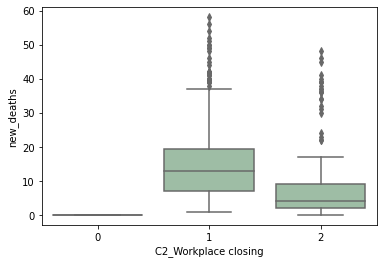

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='C2_Workplace closing', y='new_deaths', data=final_data, color='#99c2a2')
#ax = sns.swarmplot(x="C2_Workplace closing", y="new_deaths", data=final_data, color='#7d0013')
plt.show()

In [27]:
alt.Chart(final_data).transform_filter(
    "datum.total_vaccinations > -1").mark_circle().encode(
   # x='total_vaccinations',
    x = alt.X('total_vaccinations'),
           
 
    y= alt.Y('new_deaths')
)

alt.Chart(...)

In [28]:
# base = alt.Chart(final_data).encode(
#         alt.X('yearmonth(Date)')
# )

# line_A = base.mark_line(color='#5276A7').encode(
#     alt.Y('max(h_index)', axis=alt.Axis(titleColor='#5276A7')),
# )

# line_B = base.mark_line(opacity=0.5,color='red').encode(
#     alt.Y('max(cases_rate)', axis=alt.Axis(titleColor='red'))
# )


# alt.layer(line_A, line_B)



In [29]:
alt.Chart(final_data).mark_bar().encode(
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.X(alt.repeat("row"), type='nominal'),
    #color='species:N'
).properties(
    width=200,
    height=200
).repeat(
    row=['C8_International travel controls', 'C6_Stay at home requirements','C7_Restrictions on internal movement'],
    column=['new_deaths','new_cases']
).interactive()

alt.RepeatChart(...)

## Data Features Relations 

### 1. Correlation for continuas features and the target

In [30]:
#final_data['new_deaths'].corr(final_data[['new_cases','reproduction_rate']])

con_col = final_data[['Date','new_cases','new_deaths' ,'reproduction_rate','new_tests','total_tests','positive_rate','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','ICU Prev Cases','ICU Daily Cases','ICU Active Cases','c_index','h_index']]
con_col


,Date,new_cases,new_deaths,reproduction_rate,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,c_index,h_index
0,02/03/2020,1,0,1.98,160,160,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
1,03/03/2020,1,0,1.98,240,400,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
2,04/03/2020,1,0,1.98,298,698,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,16.666667
3,05/03/2020,3,0,1.98,487,1185,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,33.333333
4,06/03/2020,2,0,1.98,1024,2209,0.0017,-1.0,-1.0,-1.0,-1.0,0,0,0,0.0,33.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,27/12/2021,602,1,1.84,80804,32965869,0.0047,49953753.0,24972309.0,23101362.0,1880082.0,33,7,40,50.0,83.333333
666,28/12/2021,744,1,1.84,84060,33049929,0.0053,50215461.0,24986423.0,23125154.0,2103884.0,40,-1,39,50.0,83.333333
667,29/12/2021,752,1,1.84,84568,33134497,0.0060,50477457.0,25000071.0,23148114.0,2329272.0,39,4,43,50.0,83.333333
668,30/12/2021,819,2,1.84,95347,33229844,0.0067,50755660.0,25011556.0,23171018.0,2573086.0,43,6,49,50.0,83.333333


In [31]:
con_col.corrwith(con_col["new_deaths"]).sort_values(ascending=False)

new_deaths                 1.000000
ICU Active Cases           0.849335
ICU Prev Cases             0.849049
new_cases                  0.742894
positive_rate              0.451846
c_index                    0.175302
new_tests                  0.153990
ICU Daily Cases            0.005946
h_index                   -0.178200
total_boosters            -0.217209
reproduction_rate         -0.328532
people_vaccinated         -0.400088
people_fully_vaccinated   -0.428705
total_vaccinations        -0.434329
total_tests               -0.497297
dtype: float64

In [32]:
corr = con_col.corr()

corr.style.background_gradient(cmap='coolwarm')

,new_cases,new_deaths,reproduction_rate,new_tests,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Prev Cases,ICU Daily Cases,ICU Active Cases,c_index,h_index
new_cases,1.000000,0.742894,-0.033402,0.062575,-0.442832,0.807802,-0.329566,-0.316481,-0.364080,-0.113552,0.720843,0.330106,0.731832,0.503036,-0.097243
new_deaths,0.742894,1.000000,-0.328532,0.153990,-0.497297,0.451846,-0.434329,-0.400088,-0.428705,-0.217209,0.849049,0.005946,0.849335,0.175302,-0.178200
reproduction_rate,-0.033402,-0.328532,1.000000,-0.439998,-0.297665,0.156753,-0.166570,-0.204987,-0.117899,0.335816,-0.438213,0.317718,-0.427776,0.229540,-0.437249
new_tests,0.062575,0.153990,-0.439998,1.000000,0.502909,-0.372260,0.283431,0.258075,0.081616,0.106915,0.500311,-0.197115,0.493865,-0.439958,0.547277
total_tests,-0.442832,-0.497297,-0.297665,0.502909,1.000000,-0.548277,0.901447,0.844808,0.806569,0.374412,-0.260669,-0.208967,-0.267582,-0.474573,0.701736
positive_rate,0.807802,0.451846,0.156753,-0.372260,-0.548277,1.000000,-0.345670,-0.313911,-0.300594,-0.119007,0.302950,0.445313,0.317674,0.796403,-0.264670
total_vaccinations,-0.329566,-0.434329,-0.166570,0.283431,0.901447,-0.345670,1.000000,0.959634,0.960018,0.457998,-0.303851,-0.184246,-0.309966,-0.269282,0.487723
people_vaccinated,-0.316481,-0.400088,-0.204987,0.258075,0.844808,-0.313911,0.959634,1.000000,0.940855,0.404719,-0.297292,-0.215731,-0.304451,-0.235721,0.394325
people_fully_vaccinated,-0.364080,-0.428705,-0.117899,0.081616,0.806569,-0.300594,0.960018,0.940855,1.000000,0.500164,-0.420298,-0.184886,-0.426447,-0.210799,0.385461
total_boosters,-0.113552,-0.217209,0.335816,0.106915,0.374412,-0.119007,0.457998,0.404719,0.500164,1.000000,-0.267941,0.010481,-0.267612,-0.084026,0.191927


### 2. Correlation for categorical features and the target

In [33]:
from scipy.stats import f_oneway

def anova_test(feature):
    CategoryGroupLists=final_data.groupby(feature)['new_deaths'].apply(list)
    AnovaResults = f_oneway(*CategoryGroupLists)
    return print('P-Value for' ,feature , 'is: ',AnovaResults[1])


In [34]:
anova_test('C1_School closing')
anova_test('C2_Workplace closing')
anova_test('C3_Cancel public events')
anova_test('C4_Restrictions on gatherings')
anova_test('C5_Close public transport')
anova_test('C7_Restrictions on internal movement')
anova_test('C6_Stay at home requirements')
anova_test('C8_International travel controls')
anova_test('H2_Testing policy')
anova_test('H3_Contact tracing')
anova_test('H6_Facial Coverings')
anova_test('H7_Vaccination policy')
anova_test('H8_Protection of elderly people')


P-Value for C1_School closing is:  1.0050648822271377e-32
P-Value for C2_Workplace closing is:  1.0557649490505762e-15
P-Value for C3_Cancel public events is:  2.249827806821038e-13
P-Value for C4_Restrictions on gatherings is:  1.099839022008826e-08
P-Value for C5_Close public transport is:  0.859757266855872
P-Value for C7_Restrictions on internal movement is:  0.003223387644119704
P-Value for C6_Stay at home requirements is:  1.1159360313307767e-143
P-Value for C8_International travel controls is:  2.037753670788157e-40
P-Value for H2_Testing policy is:  1.003241702854061e-10
P-Value for H3_Contact tracing is:  0.1193998671382537
P-Value for H6_Facial Coverings is:  1.2946645367908628e-29
P-Value for H7_Vaccination policy is:  3.4062616125460105e-56
P-Value for H8_Protection of elderly people is:  5.38812416848247e-16


P-Value for H3_Contact tracing and C5_Close public transport are less than 0.05 this mean these feature doesn't have any signigcant effect on the new deaths 

## 5. Machine Learning Model

Splitting the dataset to training and testing set

In [135]:
X = final_data.drop(['H3_Contact tracing','ICU Prev Cases','C5_Close public transport','Date','new_deaths','c_index','new_tests','ICU Daily Cases','h_index'], axis=1)
y = final_data['new_deaths']
X100 = shap.utils.sample(X, 100) # 100 instances for use as the background distribution


In [105]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=1)


Sclating the data

In [106]:
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

### 5.1 Linear Regression Model

In [107]:
# Constructing the model
reg = linear_model.LinearRegression()
# Fitting the training and testing data to the model
reg.fit(X_train, y_train)

LinearRegression()

In [108]:
# Linear Regreesion prediction
y_pred = reg.predict(X_test)

In [109]:
reg_mse= np.sqrt(mean_squared_error(y_test,y_pred))
reg_r2 = r2_score(y_test, y_pred)
print('MSE: ', reg_mse)
print('R2: ', reg_r2)

MSE:  3.150842272944359
R2:  0.9297137766112102


### 5.2 Lasso Regression Model

In [110]:
# Constructing the model
lasso = linear_model.Lasso(alpha=0.1)
# Fitting the training and testing data to the model
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [111]:
# Linear Regreesion prediction
y_pred_lasso = reg.predict(X_test)

In [112]:
lasso_mse = np.sqrt(mean_squared_error(y_test,y_pred_lasso))
lasso_r2 = r2_score(y_test, y_pred_lasso)
print('MSE: ', lasso_mse)
print('R2: ', lasso_r2)

MSE:  3.150842272944359
R2:  0.9297137766112102


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e+03, tolerance: 5.788e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e+03, tolerance: 5.788e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


## 5.3 Lasso with Grid Search

In [113]:
# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(alpha=alpha)
grid = GridSearchCV(estimator=lasso, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+03, tolerance: 5.990e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e+03, tolerance: 5.788e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. Y

Best Score:  0.9337000735475005
Best Params:  {'alpha': 0.01}


#### 5.4 Ridge Regression

In [114]:
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
y_pred_rr= rr.predict(X_test)

In [115]:
rr_mse = np.sqrt(mean_squared_error(y_test,y_pred_rr))
rr_r2 = r2_score(y_test, y_pred_rr)
print('rr_mse: ', rr_mse)
print('rr_r2: ', reg_r2)

rr_mse:  3.150258363878554
rr_r2:  0.9297137766112102


In [116]:
# from sklearn.svm import SVR
# reg_svr = SVR(kernel = 'linear')
# reg_svr.fit(X_train, y_train)

# preds_svr = reg_svr.predict(X_test)
# mean_absolute_error(y_true=y_test, y_pred=preds_svr)

In [117]:
# print(r2_score(y_test, preds_svr))

In [118]:
X_featurenames = X.columns


In [119]:
X.columns

Index(['new_cases', 'reproduction_rate', 'total_tests', 'positive_rate',
       'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'total_boosters', 'ICU Active Cases', 'C1_School closing',
       'C2_Workplace closing', 'C3_Cancel public events',
       'C4_Restrictions on gatherings', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'H2_Testing policy',
       'H6_Facial Coverings', 'H7_Vaccination policy',
       'H8_Protection of elderly people'],
      dtype='object')

In [120]:
X_test

,new_cases,reproduction_rate,total_tests,positive_rate,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,ICU Active Cases,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C6_Stay at home requirements,C7_Restrictions on internal movement,C8_International travel controls,H2_Testing policy,H6_Facial Coverings,H7_Vaccination policy,H8_Protection of elderly people
657,146,1.70,32413727,0.0015,48381592.0,24872178.0,22935782.0,573632.0,33,1,1,1,3,0,1,3,3,3,5,1
397,673,1.20,15350585,0.0108,4877442.0,-1.0,-1.0,-1.0,782,3,1,2,3,0,0,3,3,3,5,1
304,137,0.92,11046767,0.0045,-1.0,-1.0,-1.0,-1.0,362,3,1,2,3,0,0,4,3,3,3,1
85,1815,1.09,795566,0.1429,-1.0,-1.0,-1.0,-1.0,968,3,2,2,4,3,2,4,2,1,0,3
60,1362,1.36,381605,0.1285,-1.0,-1.0,-1.0,-1.0,240,3,2,2,4,3,2,4,2,1,0,3
293,168,0.91,10676018,0.0042,-1.0,-1.0,-1.0,-1.0,410,3,1,2,3,0,0,4,3,3,3,1
57,1325,1.41,349839,0.1254,-1.0,-1.0,-1.0,-1.0,203,3,2,2,4,3,2,4,2,1,0,3
23,133,1.90,78078,0.0189,-1.0,-1.0,-1.0,-1.0,13,3,2,2,3,2,2,4,2,0,0,2
277,190,0.86,10073869,0.0057,-1.0,-1.0,-1.0,-1.0,603,3,1,2,3,0,0,3,3,3,0,1
248,436,0.96,8638296,0.0074,-1.0,-1.0,-1.0,-1.0,736,3,1,2,3,0,0,3,3,3,0,1


In [130]:
# constructin the LIME tabular explaination and fitting the training data
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train),
                    feature_names=X_featurenames, 
                    # selecting the categorical features by index
                   categorical_features= [10,11,12,13,14,15,16,17,18,19,20],
                    verbose=True, mode='regression')
# Trying to explain one prediction
exp = explainer.explain_instance(X_test.loc[664], reg.predict)

Intercept 15.863838922587094
Prediction_local [3.52473992]
Right: 2.2346222473661452


In [131]:
exp.show_in_notebook(show_table=True, show_all = False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+03, tolerance: 5.990e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e+01, tolerance: 5.990e+00
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. Y

In [126]:
reg.predict

<bound method LinearModel.predict of LinearRegression()>

In [134]:
import shap

In [141]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", reg.coef_[i].round(4))

Model coefficients:

new_cases = 0.0029
reproduction_rate = 1.8455
total_tests = 0.0
positive_rate = -14.5149
total_vaccinations = -0.0
people_vaccinated = -0.0
people_fully_vaccinated = 0.0
total_boosters = -0.0
ICU Active Cases = 0.0095
C1_School closing = -0.6353
C2_Workplace closing = -0.1614
C3_Cancel public events = 0.4041
C4_Restrictions on gatherings = -1.1017
C6_Stay at home requirements = 4.7333
C7_Restrictions on internal movement = -1.3259
C8_International travel controls = 1.0781
H2_Testing policy = 3.599
H6_Facial Coverings = 2.1079
H7_Vaccination policy = -2.1338
H8_Protection of elderly people = -4.0503


Permutation explainer: 671it [00:13, 13.10it/s]                                 


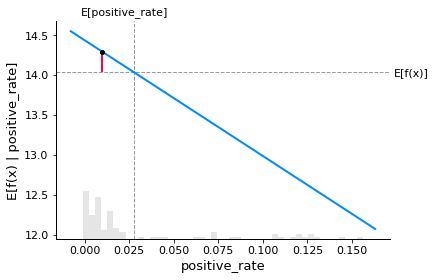

In [142]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(reg.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "positive_rate", reg.predict, X100, model_expected_value=True,
    feature_expected_value=True, ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

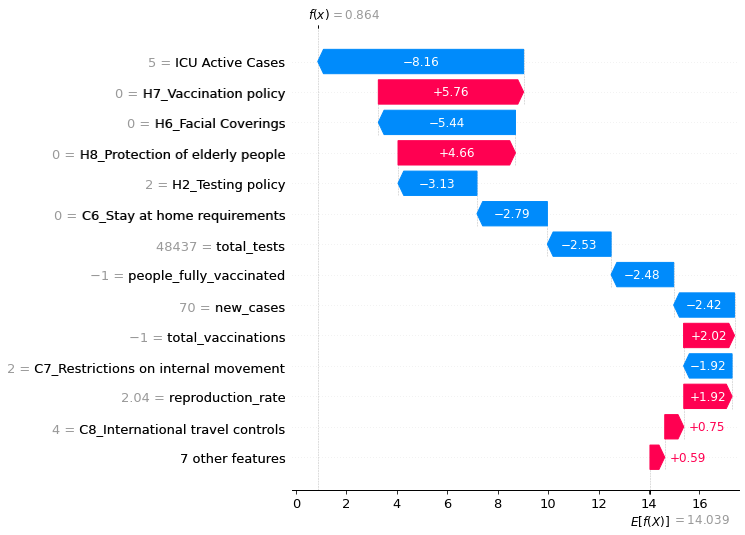

NameError: name 'shap_values_ebm' is not defined

In [157]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)
shap.plots.waterfall(shap_values_ebm[sample_ind], max_display=14)


In [160]:
explainer = shap.Explainer(reg.predict, X100)
# Calculate Shap values
#shap_values = explainer.shap_values(X_train)


In [168]:
explainer = shap.Explainer(reg.predict)


In [169]:
shap_values = explainer.shap_values(X_test)


TypeError: 'NoneType' object is not callable